xcode-select: note: Command line tools are already installed. Use "Software Update" in System Settings or the softwareupdate command line interface to install updates
zsh:1: command not found: brew


python(31102) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31103) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31104) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(31105) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(31112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Missing values in target column before cleaning: 0


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(1594397, 16)"
4,Transformed data shape,"(1594397, 16)"
5,Transformed train set shape,"(1116077, 16)"
6,Transformed test set shape,"(478320, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8762,0.8921,0.5857,0.7673,0.6643,0.5901,0.5982,1.8970
rf,Random Forest Classifier,0.8754,0.8802,0.5880,0.7618,0.6637,0.5888,0.5962,19.5480
gbc,Gradient Boosting Classifier,0.8737,0.8846,0.5778,0.7608,0.6568,0.5812,0.5894,14.8470
et,Extra Trees Classifier,0.8697,0.8680,0.5748,0.7439,0.6485,0.5701,0.5773,28.0440
ada,Ada Boost Classifier,0.8664,0.8764,0.5317,0.7569,0.6246,0.5463,0.5589,3.1840
lr,Logistic Regression,0.8504,0.8429,0.4205,0.7557,0.5403,0.4595,0.4877,5.1480
ridge,Ridge Classifier,0.8470,0.8430,0.3753,0.7781,0.5064,0.4287,0.4686,0.1320
lda,Linear Discriminant Analysis,0.8462,0.8430,0.4424,0.7132,0.5461,0.4596,0.4786,0.2880
knn,K Neighbors Classifier,0.8327,0.7701,0.4033,0.6647,0.5020,0.4086,0.4271,1.3810
dt,Decision Tree Classifier,0.8126,0.7259,0.5750,0.5494,0.5619,0.4427,0.4429,0.7860


Best Model:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8750,0.8911,0.5810,0.7656,0.6606,0.5858,0.5942


Accuracy: 0.874982438534872
Precision: 0.765618587618777
Recall: 0.5809816979685704
F1 Score: 0.6606420506394628
Confusion Matrix: 
[[300263  14849]
 [ 34983  48505]]


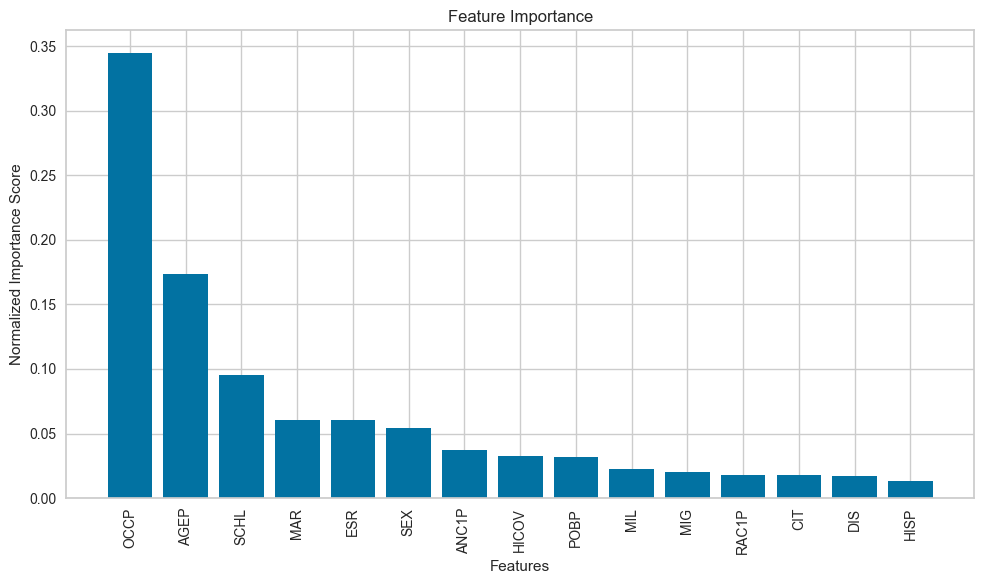

Feature Importances:
OCCP: 0.3450
AGEP: 0.1737
SCHL: 0.0957
MAR: 0.0607
ESR: 0.0607
SEX: 0.0547
ANC1P: 0.0370
HICOV: 0.0323
POBP: 0.0317
MIL: 0.0223
MIG: 0.0203
RAC1P: 0.0180
CIT: 0.0177
DIS: 0.0170
HISP: 0.0133


In [18]:
# Install necessary dependencies
!xcode-select --install
!brew install gfortran
!pip install --upgrade pip setuptools wheel
!pip install scipy

# Install PyCaret
!pip install pycaret -q

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pycaret.classification import setup, compare_models, finalize_model, save_model, load_model, predict_model

# Define the file path
file_path = '/Users/sherryzhang/Downloads/DroppedMisVals.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Define features and target
poverty_threshold = 13590
Y = np.where(data['PINCP'] <= poverty_threshold, 1, 0)

# Add the target column to the dataframe
data['target'] = Y

# Check for missing values in the target column
print(f"Missing values in target column before cleaning: {data['target'].isna().sum()}")

# Remove rows with missing values in the target column
data = data.dropna(subset=['target'])

# Redefine features and target after removing missing values
X = data.drop(['PINCP', 'target'], axis=1)
Y = data['target']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18)

# Combine training features and target into one dataframe for PyCaret
train_data = pd.concat([pd.DataFrame(X_train), pd.Series(Y_train, name='target')], axis=1)

# Set up the PyCaret environment
clf_setup = setup(data=train_data, target='target', session_id=123)

# Compare all models and select the best one
best_model = compare_models()

# Print the best model to see which one was selected
print("Best Model: ", best_model)

# Finalize the model (train on the entire training set)
final_model = finalize_model(best_model)

# Save the model
save_model(final_model, '/Users/sherryzhang/Downloads/best_model')

# Load the model (if needed in future)
loaded_model = load_model('/Users/sherryzhang/Downloads/best_model')

# Evaluate the model on the test set
test_data = pd.concat([pd.DataFrame(X_test), pd.Series(Y_test, name='target')], axis=1)
predictions_df = predict_model(loaded_model, data=test_data)

# Use the correct column for predicted class labels
predictions = predictions_df['prediction_label']

# Metrics
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
conf_matrix = confusion_matrix(Y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Feature importance
feature_importance = final_model.feature_importances_
total_importance = sum(feature_importance)
normalized_importance = feature_importance / total_importance

indices = np.argsort(normalized_importance)[::-1]
names = [X.columns[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(normalized_importance)), normalized_importance[indices], align='center')
plt.xticks(range(len(normalized_importance)), names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Normalized Importance Score')
plt.tight_layout()
plt.show()

# Print the feature importance values
print("Feature Importances:")
for name, importance in zip(names, normalized_importance[indices]):
    print(f"{name}: {importance:.4f}")

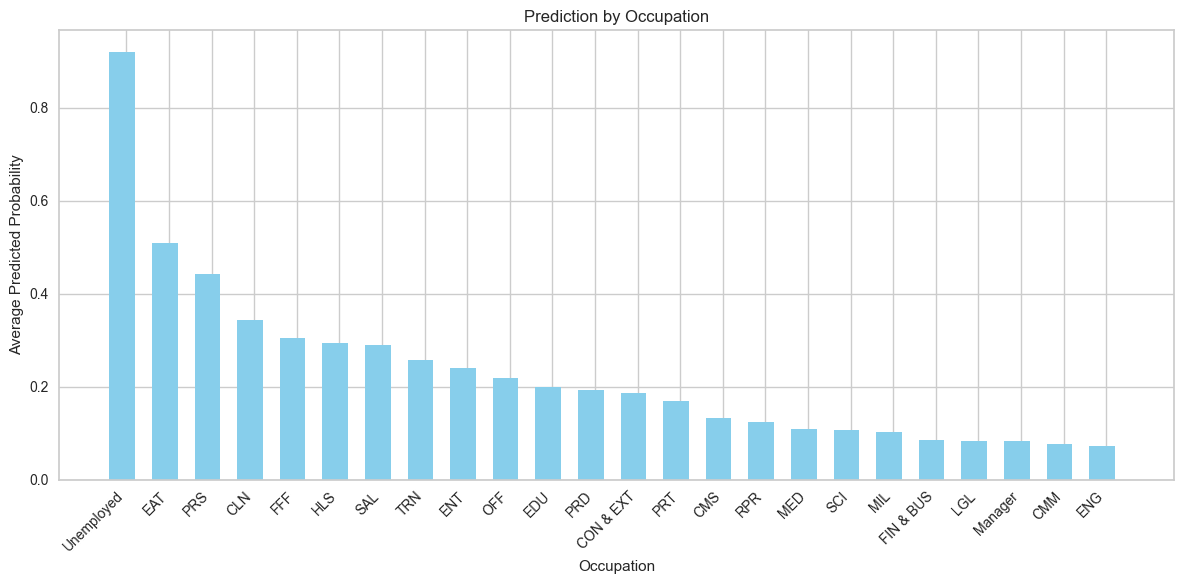

In [19]:
import matplotlib.pyplot as plt

# Define the occupation code ranges and their corresponding names
OCCPs = [(10, 440, "Manager"), (500, 960, "FIN & BUS"),
         (1005, 1240, "CMM"),
         (1305, 1560, "ENG"),
         (1600, 1980, "SCI"),
         (2001, 2060, "CMS"),
         (2100, 2180, "LGL"),
         (2205, 2555, "EDU"),
         (2600, 2920, "ENT"),
         (3000, 3550, "MED"),
         (3601, 3655, "HLS"),
         (3700, 3960, "PRT"),
         (4000, 4160, "EAT"),
         (4200, 4255, "CLN"),
         (4330, 4655, "PRS"),
         (4700, 4965, "SAL"),
         (5000, 5940, "OFF"),
         (6005, 6130, "FFF"),
         (6200, 6950, "CON & EXT"),
         (7000, 7640, "RPR"),
         (7700, 8990, "PRD"),
         (9005, 9760, "TRN"),
         (9800, 9830, "MIL"),
         (9920, 9920, "Unemployed")]

avg_probs = []
occupations = []

for OCCP in OCCPs:
    # Filter data within the current occupation code range
    subset_indices = (X_test['OCCP'] >= OCCP[0]) & (X_test['OCCP'] <= OCCP[1])
    subset_X = X_test.loc[subset_indices]

    # Use boolean indexing for NumPy arrays
    subset_Y = Y_test[subset_indices]

    # Calculate average predicted probability for the current range
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean()
    avg_probs.append(avg_prob)

    # Store the corresponding occupation name for plotting
    occupations.append(OCCP[2])

# Sort avg_probs and corresponding occupations based on avg_probs
avg_probs, occupations = zip(*sorted(zip(avg_probs, occupations), reverse=True))

# Plotting the bar chart with adjusted figure size and bar width
plt.figure(figsize=(12, 6))  # Adjust figure size
bars = plt.bar(occupations, avg_probs, color='skyblue')

# Adjusting bar width and spacing between bars
for bar in bars:
    bar.set_width(0.6)  # Adjust bar width
plt.xlabel("Occupation")
plt.ylabel("Average Predicted Probability")
plt.title("Prediction by Occupation")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensures all labels are visible
plt.show()


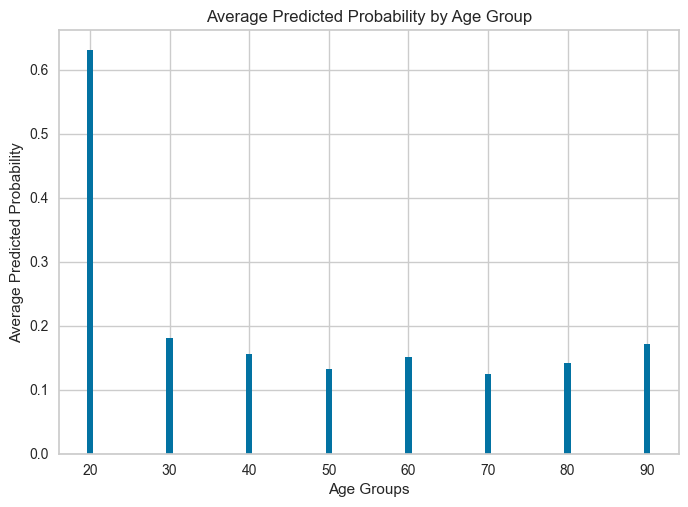

In [20]:
age_groups = [20, 30, 40, 50, 60, 70, 80, 90]  # Example age groups
avg_probs = []

for age in age_groups:
    subset_indices = X_test['AGEP'] == age
    subset_X = X_test[subset_indices]
    subset_Y = Y_test[subset_indices]
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean()
    avg_probs.append(avg_prob)

# Plot average predicted probability for each age group
plt.bar(age_groups, avg_probs)
plt.xlabel("Age Groups")
plt.ylabel("Average Predicted Probability")
plt.title("Average Predicted Probability by Age Group")
plt.show()

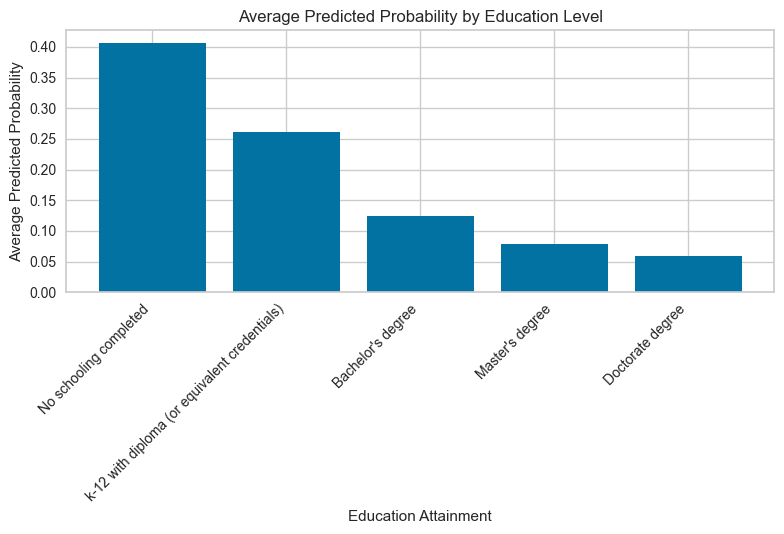

In [21]:
import matplotlib.pyplot as plt

EduLvl = [(1, 15, "No schooling completed"),
         (16, 17, "k-12 with diploma (or equivalent credentials)"),
         (21, 21, "Bachelor's degree"),
         (22, 22, "Master's degree"),
         (24, 24, "Doctorate degree")]

avg_probs = []
edu_lvls = [] # List to store names of education levels for the plot

for SCHL in EduLvl:
    # Assuming 'SCHL' is the correct column name in your DataFrame for education level
    subset_indices = (X_test['SCHL'] >= SCHL[0]) & (X_test['SCHL'] <= SCHL[1])
    subset_X = X_test[subset_indices]
    subset_Y = Y_test[subset_indices]
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean()
    avg_probs.append(avg_prob)
    edu_lvls.append(SCHL[2]) # Append the name of the education level

# Plotting
plt.bar(edu_lvls, avg_probs)
plt.xlabel("Education Attainment")
plt.ylabel("Average Predicted Probability")
plt.title("Average Predicted Probability by Education Level")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Ensures all labels are visible
plt.show()

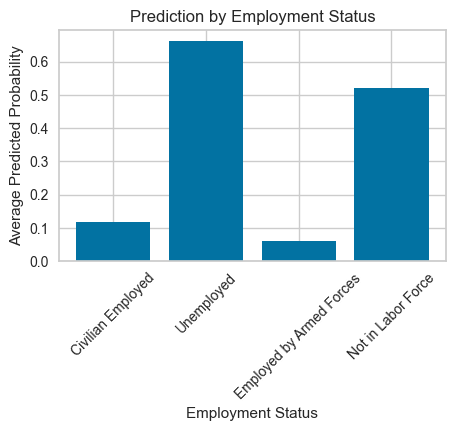

In [22]:
import matplotlib.pyplot as plt

# Define the ESR groups with appropriate labels
ESR_groups = [(1, 2, 'Civilian Employed'), (3, 3, 'Unemployed'), (4, 5, 'Employed by Armed Forces'), (6, 6, 'Not in Labor Force')]

# List to store average probabilities for each group
avg_probs = []

# Calculate average predicted probabilities for each ESR group
for start, end, label in ESR_groups:
    subset_indices = (X_test['ESR'] >= start) & (X_test['ESR'] <= end)
    subset_X = X_test[subset_indices]
    subset_Y = Y_test[subset_indices]
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean()
    avg_probs.append(avg_prob)

# Extract labels for plotting
labels = [label for _, _, label in ESR_groups]

# Plotting the results with a smaller figure size
plt.figure(figsize=(5, 3))
plt.bar(labels, avg_probs)
plt.xlabel("Employment Status")
plt.ylabel("Average Predicted Probability")
plt.title("Prediction by Employment Status")
plt.xticks(rotation=45)
plt.show()

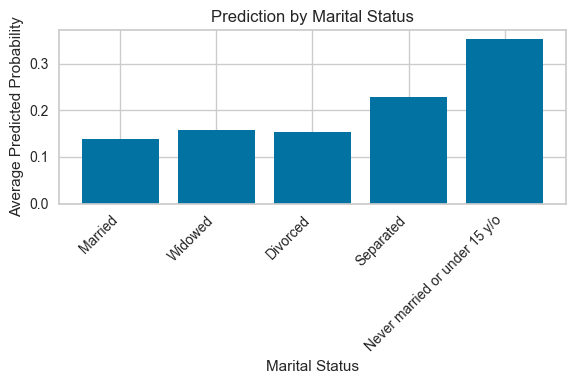

In [23]:
import matplotlib.pyplot as plt

# Define marital statuses with appropriate labels
MarStatus = [
    (1, 1, "Married"),
    (2, 2, "Widowed"),
    (3, 3, "Divorced"),
    (4, 4, "Separated"),
    (5, 5, "Never married or under 15 y/o")
]

avg_probs = []
mar_labels = []

# Calculate average predicted probabilities for each marital status
for start, end, label in MarStatus:  # Unpack the tuple correctly
    # Assuming 'MAR' is the correct column name in your DataFrame for marital status
    subset_indices = (X_test['MAR'] >= start) & (X_test['MAR'] <= end) 
    subset_X = X_test[subset_indices]
    # Handle potential empty subsets to avoid errors
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean() if len(subset_X) > 0 else 0  
    avg_probs.append(avg_prob)
    mar_labels.append(label)

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(mar_labels, avg_probs)
plt.xlabel("Marital Status")
plt.ylabel("Average Predicted Probability")
plt.title("Prediction by Marital Status")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensures all labels are visible
plt.show()


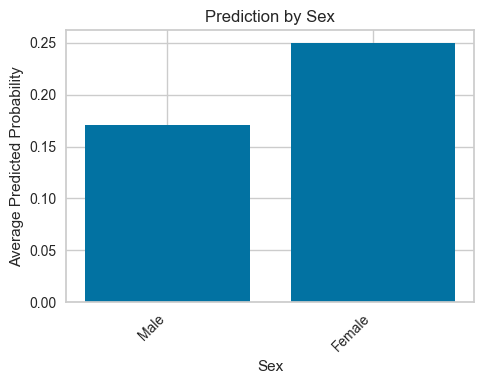

In [24]:
import matplotlib.pyplot as plt

# Define sexes with appropriate labels
Sex = [
    (1, 1, "Male"),
    (2, 2, "Female"),
]

avg_probs = []
sex_labels = []

# Calculate average predicted probabilities for each sex
for start, end, label in Sex:  # Unpack the tuple correctly
    # Assuming 'SEX' is the correct column name in your DataFrame for sex
    subset_indices = (X_test['SEX'] >= start) & (X_test['SEX'] <= end) 
    subset_X = X_test[subset_indices]
    # Handle potential empty subsets to avoid errors
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean() if len(subset_X) > 0 else 0  
    avg_probs.append(avg_prob)
    sex_labels.append(label)

# Plotting
plt.figure(figsize=(5, 4))
plt.bar(sex_labels, avg_probs)
plt.xlabel("Sex")
plt.ylabel("Average Predicted Probability")
plt.title("Prediction by Sex")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensures all labels are visible
plt.show()
